### Radiative-convective equilibrium as an idealized problem for climate

### Background on konrad 

`konrad` is a modern implementation of a single-column radiative-convective equilibrium model. In other sections of the course you'll be using very small models for which it will be straightforward enough to read the entire implementation. `konrad` is more involved so the focus will be on framing and answering questions and interpreting the results. 

The model's technical documention -- lists of all the components and functions -- is available on [ReadTheDocs](https://konrad.readthedocs.io). The konrad authors' ["How to konrad"](https://atmtools.github.io/konrad) Jupyter book is a tutorial in using the model. All the questions we asked below are found in the tutorial but you should arrive at your own answers. 

### The assignment

In the next two labs we will use konrad to explore questions of climate, including characterizing forcing, feedbacks, and climate sensitivty. Much of the material is covered in  Kluft et al. 2019, Re-examining the first climate models: climate sensitivity of a modern radiative–convective equilibrium model, doi:[10.1175/JCLI-D-18-0774.1](https://doi.org/10.1175/JCLI-D-18-0774.1).

#### Preliminaries (do in class) 

The konrad developers have provided ...

In [3]:
conda install -y colorcet seaborn 

Solving environment: | 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/noarch::cbsyst==0.4.2=pyhd8ed1ab_0
  - conda-forge/linux-64::matplotlib==3.6.3=py310hff52083_0
  - conda-forge/linux-64::contourpy==1.0.7=py310hdf3cbec_0
  - conda-forge/noarch::kgen==0.0.2=pyhd8ed1ab_0
  - conda-forge/linux-64::scikit-learn==1.2.1=py310h209a8ca_0
  - conda-forge/linux-64::scipy==1.10.0=py310h8deb116_0
  - conda-forge/linux-64::pandas==1.5.3=py310h9b08913_0
  - conda-forge/linux-64::matplotlib-base==3.6.3=py310he60537e_0
  - conda-forge/noarch::uncertainties==3.1.7=pyhd8ed1ab_0
  - conda-forge/noarch::pymyami==2.0a6=pyhd8ed1ab_0
done


==> WARNING: A newer version of conda exists. <==
  current version: 4.13.0
  latest version: 22.11.1

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /srv/conda/envs/notebook

  added / updated specs:
    - c

In [4]:
# Import needed Python modules 
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

import numpy as np

import konrad

In [5]:
# Choose pressure levels according to Equation 1 in Kluft et al. 2019 
# https://konrad.readthedocs.io/_autosummary/konrad.utils.get_quadratic_pgrid.html#konrad.utils.get_quadratic_pgrid
phlev = konrad.utils.get_quadratic_pgrid(1000e2, 10, 128) 

# Initial temperature profiles and composition 
atmosphere = konrad.atmosphere.Atmosphere(phlev)
atmosphere.atmosphere_variables

['T',
 'H2O',
 'N2O',
 'O3',
 'O2',
 'CO2',
 'CO',
 'CH4',
 'CFC11',
 'CFC12',
 'CFC22',
 'CCl4']

konrad defines an RCE calculation as a [set of choices](https://konrad.readthedocs.io/_autosummary/konrad.core.RCE.__init__.html). Many of the most important choices (radiation, ozone, humidity, surface, cloud, convection/vertical mixing, lapse rate, and large-scale upwelling) are specified as functions rather than discrete values. Start with the default configuation: 

In [6]:
initial_conds = atmosphere.copy()
baseline = konrad.RCE(atmosphere, timestep='24h', max_duration='150d')

Many of the sub-models have variables associated with them: 

In [7]:
baseline.radiation.data_vars 

{'lw_htngrt': (('time', 'plev'), None),
 'lw_htngrt_clr': (('time', 'plev'), None),
 'lw_flxu': (('time', 'phlev'), None),
 'lw_flxd': (('time', 'phlev'), None),
 'lw_flxu_clr': (('time', 'phlev'), None),
 'lw_flxd_clr': (('time', 'phlev'), None),
 'sw_htngrt': (('time', 'plev'), None),
 'sw_htngrt_clr': (('time', 'plev'), None),
 'sw_flxu': (('time', 'phlev'), None),
 'sw_flxd': (('time', 'phlev'), None),
 'sw_flxu_clr': (('time', 'phlev'), None),
 'sw_flxd_clr': (('time', 'phlev'), None),
 'net_htngrt': (('time', 'plev'), None),
 'net_htngrt_clr': (('time', 'plev'), None),
 'toa': (('time',), None)}

Two interleaved grids are used in the vertical: state variables (temperature, concentration, humidity) are on full levels (`plev`), while fluxes (especially radiation variables) are on half-levels (`phlev`). The surface is at `phlev[0]` and there's one more half-level than full level. 

Variables are undefined until the model is run, normally to convergence, which takes about 10 seconds on the LEAPangeo hub

In [8]:
baseline.run() 

Variables will now have valid values. The first axis is time but, by default, only the values at equilibrium are available: 

In [15]:
baseline.radiation["lw_flxu"].shape

(1, 128)

Note that the `atmosphere` variable itself also has the new values 

In [16]:
print(np.max(atmosphere['T'] - baseline.atmosphere['T']))

0.0


We can, for example, plot the arbitrary initial and final equilibrium profiles of temperature. We'll plot these as a function of pressure, which varies over three orders of magnitude (so we use a log scale) and decreases as altitide increases (so we'll plot an inverted y-axis). 

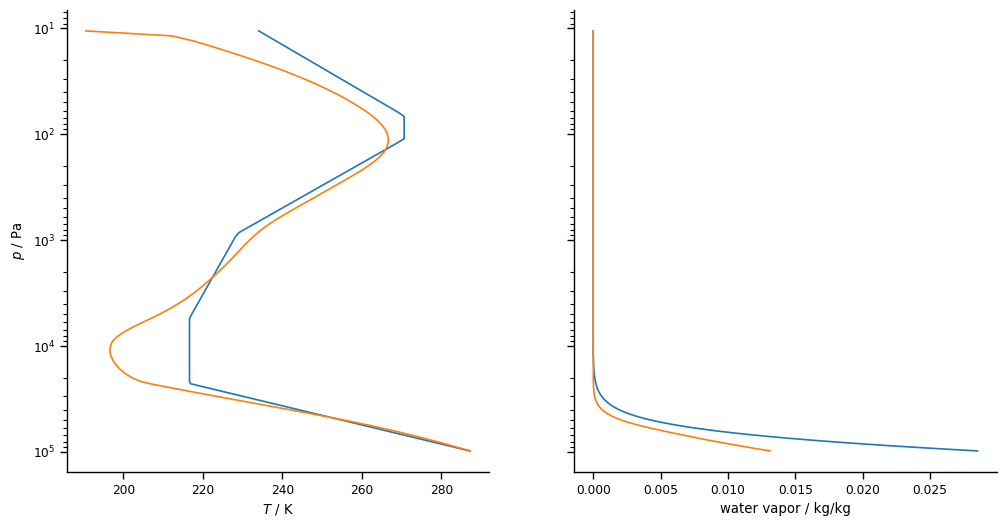

In [17]:
sns.set_context("paper")

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=[12, 6], sharey=True)
ax0.semilogy(initial_conds['T'][0,:], initial_conds['plev'])
ax0.semilogy(atmosphere   ['T'][0,:], initial_conds['plev'])
ax0.set_ylabel("$p$ / Pa")
ax0.set_xlabel("$T$ / K")
ax0.invert_yaxis()

ax1.semilogy(initial_conds['H2O'][0,:], initial_conds['plev'])
ax1.semilogy(atmosphere   ['H2O'][0,:], initial_conds['plev'])
ax1.set_xlabel("water vapor / kg/kg")

sns.despine() 

What does the energy budget look like in the baseline RCE state? We can plot the four components of the radiation budget: up- and down-going radiation for solar (shortwave or sw) and terrestrial (longwave or lw) radiation. The radiation model also tells us the net heating rate. 

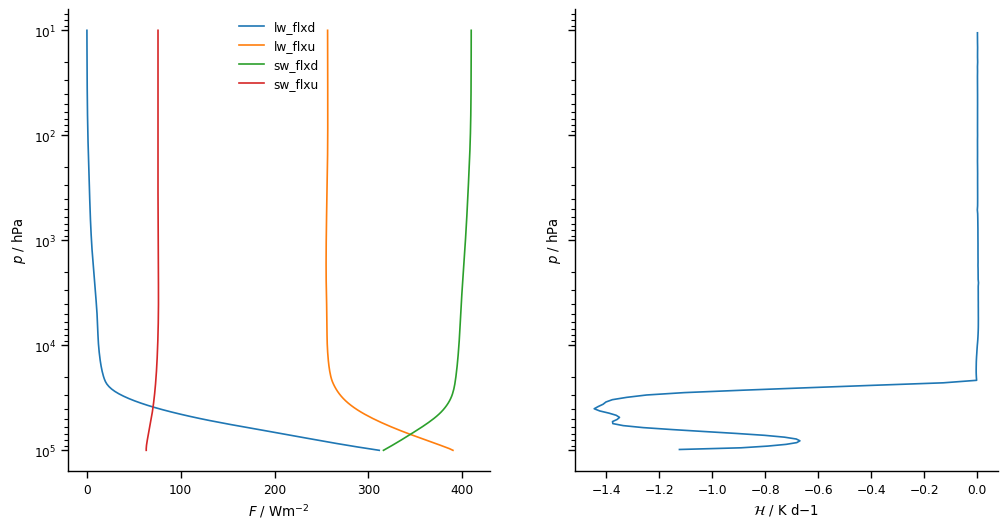

In [18]:
# If we were doing this for publication we'd assign each variable a distinct color 

sns.set_context("paper")

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=[12, 6], sharey=True)
for v in ['lw_flxd', 'lw_flxu', 'sw_flxd', 'sw_flxu']:
    ax0.semilogy(baseline.radiation[v][0,:], initial_conds['phlev'], label=v)
ax0.set_ylabel("$p$ / hPa")
ax0.set_xlabel("$F$ / Wm$^{-2}$")
ax0.legend(frameon = False) 
ax0.invert_yaxis()


ax1.semilogy(baseline.radiation['net_htngrt'][0,:],       initial_conds['plev'])
ax1.set_ylabel("$p$ / hPa")
ax1.set_xlabel("$\mathcal{H}$ / K d${-1}$")

sns.despine() 

Compare the down-going and up-going amounts of solar and terrestrial radiation. Do you understand why they have the relative values they do?  

At pressures greater than 1000 Pa, or 100 hPa, i.e. in the lowest 90% of mass in the atmopheres, there's a non-zero radiative cooling rate of roughly 1 $K/d$. That's the cooling that's making the atmosphere unstable and leading to convection. 

The upper part of the atmosphere -- the stratosphere and above -- is in radiative equilibrium. 

What is the total top-of-atmosphere energy imbalance? 

#### Question 1 
What is the temperature struture of the (tropical) atmosphere under present-day conditions (that's the figure above), and how does this depend on humidity (and maybe insolation)? (A bit on how lapse rate varies with surface T?)

In [19]:
# Show how to set the solar constant
# Show how to change the humidity - what sets the default/initial profile
# Show how to change the surface temperature 

#### Question 2
What is the instantaneous radiative forcing due to doubling CO2 concentrations from pre-industrial values, and how does this depend on humidity and temperature? 

In [20]:
# Show how to compute radiation on a given set of atmospheric conditions, e.g. the example from How to Konrad: 

olr_ref = baseline.radiation["lw_flxu"][0,:]
# Calculate OLR at perturbed atmospheric state.
atmosphere["CO2"][:] *= 2  # double the CO2 concentration
baseline.radiation.update_heatingrates(atmosphere)

inst_rad_forcing = -(baseline.radiation["lw_flxu"][0,:] - olr_ref)

#### Question 3 
What is the effective radiative forcing due to doubling CO2 concentrations from pre-industrial values, and what is the relationship between stratospheric cooling and the radiative adjustment? 

In [21]:
# This requires stashing the atmospheric conditions, running the model to a new equilibrium. 
# Maybe ask people to show profiles of forcing and temperture change? 

#### Question 4
What is the climate sensitivity in RCE. Does this depend on temperature? Humidity? Estimate by changing surface T; estimate again by changing atmospheric composition and running to equilibrium. 